In [2]:
%load_ext autoreload
%autoreload 2
# 
from srf.helpers import evar,add_noise_with_snr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tools.rsa import compute_similarity
from srf.mixed.admm import admm_symnmf_masked, train_val_split, ADMM, find_best_rank
from srf.datasets import load_dataset
from srf.helpers import median_matrix_split, best_pairwise_match, zero_matrix_split
from srf.plotting import plot_images_from_embedding
import seaborn as sns
import pandas as pd

def plot_rank_selection(df_full, df_pos, df_neg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    # Plot full dataframes with variance across repeats
    sns.lineplot(data=df_full, x="rank", y="rmse", ax=ax1, errorbar="sd")
    ax1.set_title("Full RSM")
    ax1.axvline(
        x=df_full.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_pos, x="rank", y="rmse", ax=ax2, errorbar="sd")
    ax2.set_title("Positive")
    ax2.axvline(
        x=df_pos.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_neg, x="rank", y="rmse", ax=ax3, errorbar="sd")
    ax3.set_title("Negative")
    ax3.axvline(
        x=df_neg.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )


    plt.tight_layout()
    plt.show()

    # Calculate best ranks using mean RMSE
    rank_pos = df_pos.groupby("rank")["rmse"].mean().idxmin()
    rank_neg = df_neg.groupby("rank")["rmse"].mean().idxmin()
    rank_all = df_full.groupby("rank")["rmse"].mean().idxmin()

    print(f"best rank for positive matrix: {rank_pos}")
    print(f"best rank for negative matrix: {rank_neg}")
    print(f"best rank for all matrix: {rank_all}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
dataset = load_dataset("peterson-animals")

images = dataset.images
rsm = dataset.rsm
n = rsm.shape[0]
repeats = 10
s_plus, s_minus, thresh, mask = median_matrix_split(rsm)

ratio = 0.3
df_full = find_best_rank(
    rsm,
    range(1, 30),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_pos = find_best_rank(
    s_plus,
    range(1, 30),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_neg = find_best_rank(
    s_minus,
    range(1, 30),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)

plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5168055555555555


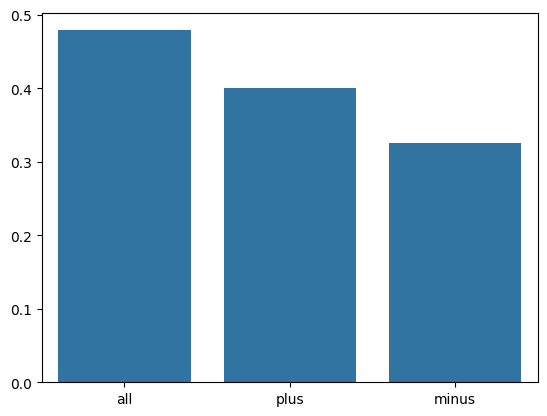

In [31]:
model = ADMM(rank=2, max_outer=10, w_inner=40, tol=0.0, verbose=False)
mask = np.ones_like(rsm)
model.fit(rsm, mask=mask)
evar_all = model.history_["evar"][-1]
model.fit(s_minus, mask=mask)
evar_minus = model.history_["evar"][-1]
model.fit(s_plus, mask=mask)
evar_plus = model.history_["evar"][-1]

# make a seaborn bar plot of the explain variance of the three matrices
sns.barplot(x=["all", "plus", "minus"], y=[evar_all, evar_plus, evar_minus])
plt.show()

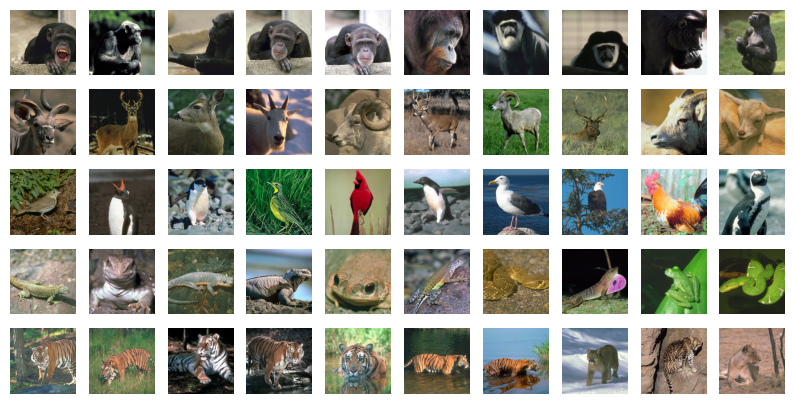

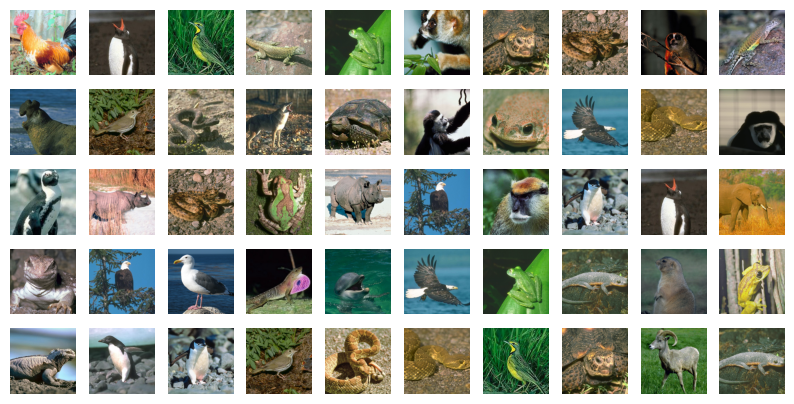

In [48]:
model = ADMM(rank=5, max_outer=100, w_inner=20, tol=0.0, verbose=True)
w_plus = model.fit_transform(s_plus)
w_minus = model.fit_transform(s_minus)

fig = plot_images_from_embedding(w_plus, images, top_k=10, dpi=100)
fig = plot_images_from_embedding(w_minus, images, top_k=10, dpi=100)

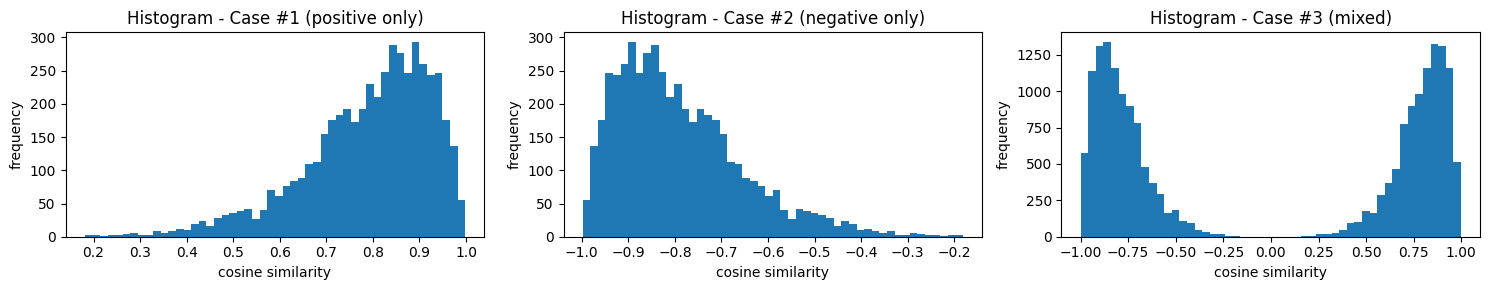

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_each = 100
dim = 5
bins = 50
rng = np.random.default_rng(0)

x_pos = rng.random((n_each, dim))
x_pos /= np.linalg.norm(x_pos, axis=1, keepdims=True)

x_neg = -x_pos
x_neg /= np.linalg.norm(x_neg, axis=1, keepdims=True)

rsm_pos = x_pos @ x_pos.T
rsm_neg = x_pos @ x_neg.T
x_all = np.vstack([x_pos, x_neg])
rsm_all = x_all @ x_all.T


def upper(vec):
    return vec[np.triu_indices_from(vec, k=1)]


fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].hist(upper(rsm_pos), bins=bins)
axes[0].set_title("Histogram - Case #1 (positive only)")
axes[0].set_xlabel("cosine similarity")
axes[0].set_ylabel("frequency")

axes[1].hist(upper(rsm_neg), bins=bins)
axes[1].set_title("Histogram - Case #2 (negative only)")
axes[1].set_xlabel("cosine similarity")
axes[1].set_ylabel("frequency")

axes[2].hist(upper(rsm_all), bins=bins)
axes[2].set_title("Histogram - Case #3 (mixed)")
axes[2].set_xlabel("cosine similarity")
axes[2].set_ylabel("frequency")


plt.tight_layout()
plt.show()

fraction of positive values: 0.5


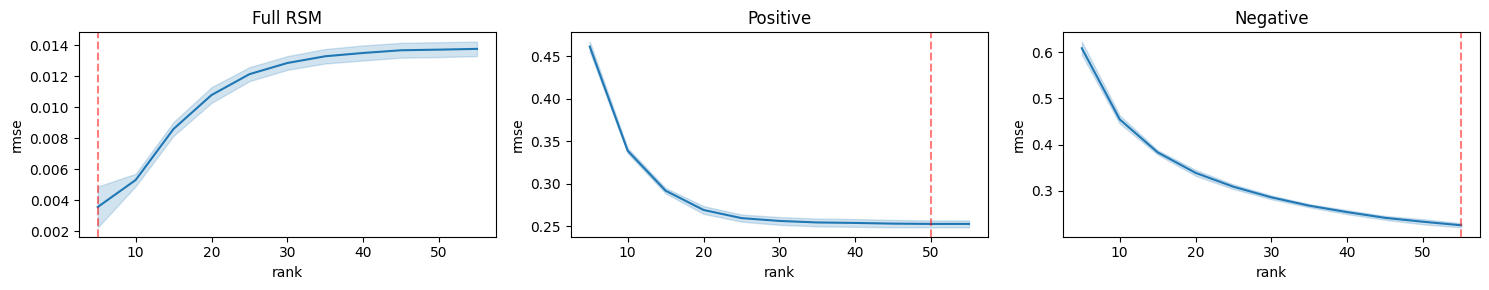

best rank for positive matrix: 50
best rank for negative matrix: 55
best rank for all matrix: 5


In [16]:
s_plus_plus, s_plus_minus, thresh_plus, mask_plus = median_matrix_split(rsm_pos)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_pos,
    range(5, 60, 5),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
df_pos = find_best_rank(
    s_plus_plus,
    range(5, 60, 5),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
df_neg = find_best_rank(
    s_plus_minus,
    range(5, 60, 5),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5


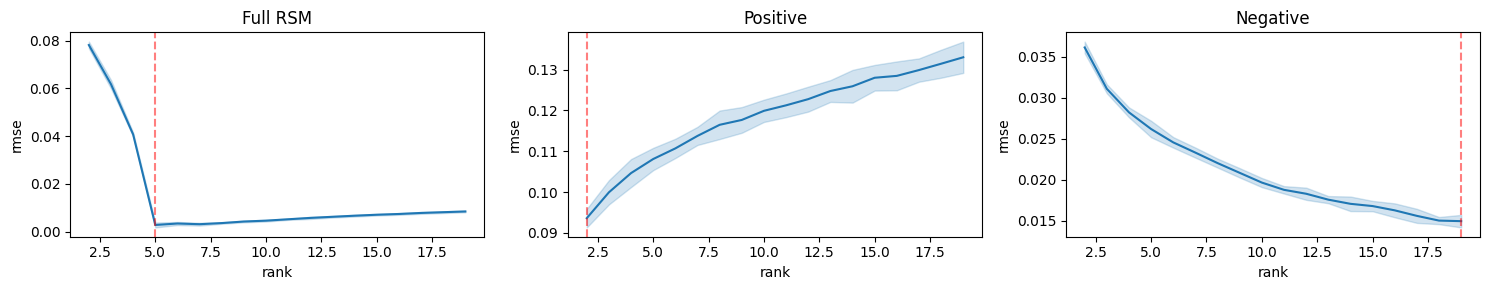

best rank for positive matrix: 2
best rank for negative matrix: 19
best rank for all matrix: 5


In [116]:
s_minus_plus, s_minus_minus, thresh_minus, mask_minus = median_matrix_split(rsm_neg)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_pos,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
df_pos = find_best_rank(
    s_minus_plus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
df_neg = find_best_rank(
    s_minus_minus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5


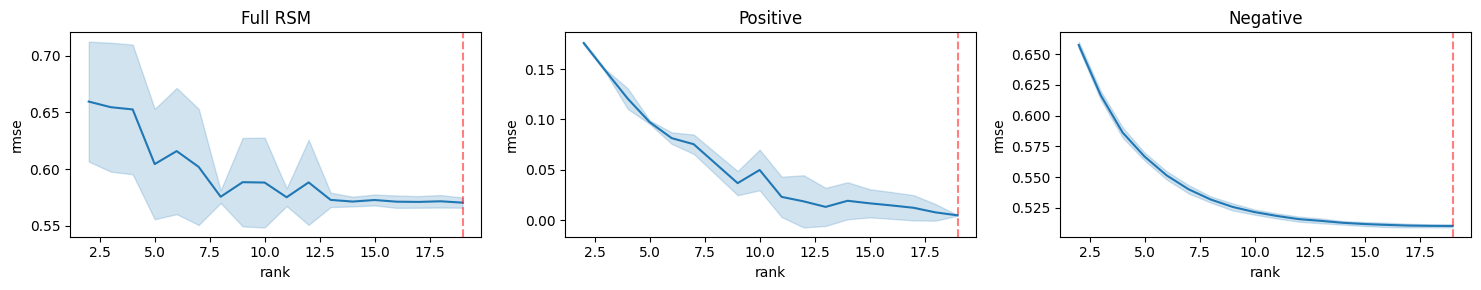

best rank for positive matrix: 19
best rank for negative matrix: 19
best rank for all matrix: 19


In [21]:
s_all_plus, s_all_minus, thresh_all, mask_all = median_matrix_split(rsm_all)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_all,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
df_pos = find_best_rank(
    s_all_plus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
df_neg = find_best_rank(
    s_all_minus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

In [106]:
model = ADMM(rank=5, max_outer=30, w_inner=20, tol=0.0, verbose=True)
w_pos = model.fit_transform(s_plus, mask=mask)
w_neg = model.fit_transform(s_minus, mask=~mask)

s_hat = w_pos @ w_pos.T - w_neg @ w_neg.T
print(evar(rsm_all, s_hat))

0.28525310611100210.359081 | Evar: 0.994843 | Recon: 0.372463 | Penalty: 0.000520 | Lag: -0.013902149780166


### Below we check if there is a power law or somethig similar between the nuber of objects and the optimal training ratio

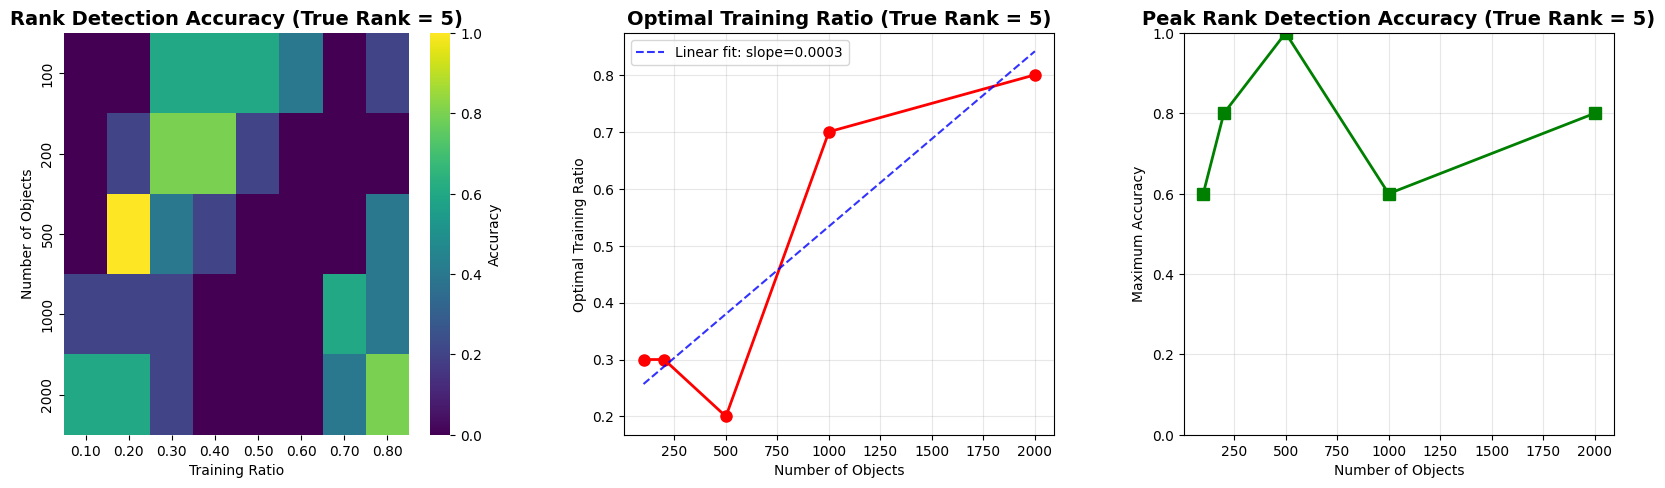

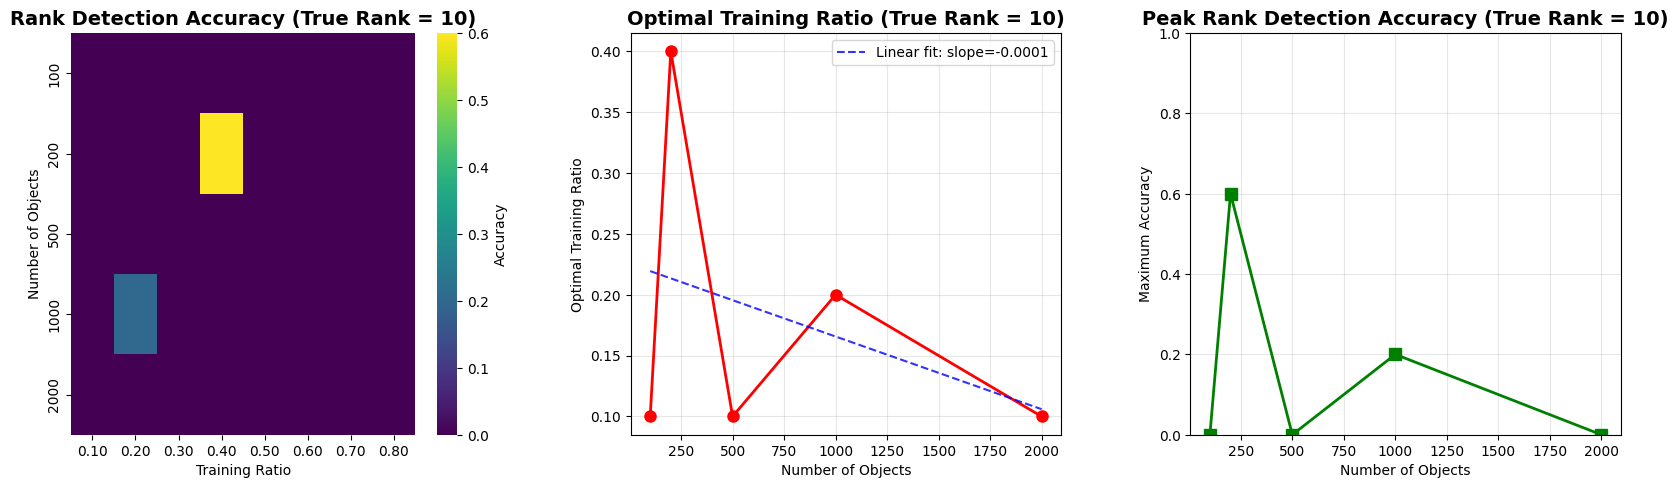

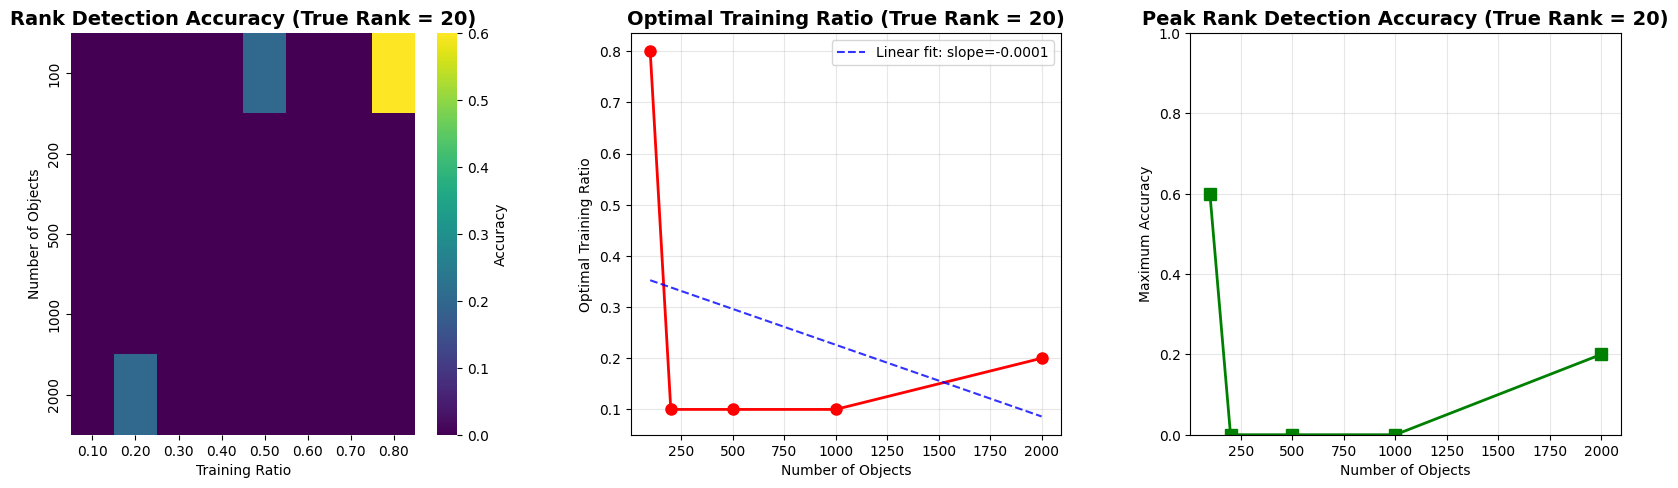

([np.int64(100), np.int64(200), np.int64(500), np.int64(1000), np.int64(2000)],
 [np.float64(0.8),
  np.float64(0.1),
  np.float64(0.1),
  np.float64(0.1),
  np.float64(0.2)],
 [np.float64(0.6),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.2)])

In [17]:
def create_main_plots(summary_df, save_path=None):
    """Create the main visualization plots for each true rank separately"""

    # Get unique true ranks
    true_ranks = sorted(summary_df["true_rank"].unique())

    for true_rank in true_ranks:
        # Filter data for current true rank
        rank_df = summary_df[summary_df["true_rank"] == true_rank]

        plt.style.use("default")
        fig = plt.figure(figsize=(20, 12))

        # Create a 2x3 grid of subplots
        gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

        # Get unique object counts for analysis
        n_objects_list = sorted(rank_df["n_objects"].unique())

        # 1. Heatmap of accuracy across all conditions
        ax1 = fig.add_subplot(gs[0, 0])
        pivot_data = rank_df.pivot(
            index="n_objects", columns="train_ratio", values="accuracy_mean"
        )
        sns.heatmap(
            pivot_data,
            annot=False,
            cmap="viridis",
            ax=ax1,
            cbar_kws={"label": "Accuracy"},
        )
        ax1.set_title(
            f"Rank Detection Accuracy (True Rank = {true_rank})",
            fontsize=14,
            fontweight="bold",
        )
        ax1.set_xlabel("Training Ratio")
        ax1.set_ylabel("Number of Objects")
        # Format x-axis labels to show only one decimal place
        ax1.set_xticklabels(
            [f"{float(x.get_text()):.2f}" for x in ax1.get_xticklabels()]
        )

        # 2. Line plot showing optimal ratio for each object count
        ax2 = fig.add_subplot(gs[0, 1])
        optimal_ratios = []
        object_counts = []

        for n_obj in n_objects_list:
            subset = rank_df[rank_df["n_objects"] == n_obj]
            best_ratio = subset.loc[subset["accuracy_mean"].idxmax(), "train_ratio"]
            optimal_ratios.append(best_ratio)
            object_counts.append(n_obj)

        ax2.plot(
            object_counts, optimal_ratios, "o-", linewidth=2, markersize=8, color="red"
        )
        ax2.set_xlabel("Number of Objects")
        ax2.set_ylabel("Optimal Training Ratio")
        ax2.set_title(
            f"Optimal Training Ratio (True Rank = {true_rank})",
            fontsize=14,
            fontweight="bold",
        )
        ax2.grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(object_counts, optimal_ratios, 1)
        p = np.poly1d(z)
        ax2.plot(
            object_counts,
            p(object_counts),
            "--",
            alpha=0.8,
            color="blue",
            label=f"Linear fit: slope={z[0]:.4f}",
        )
        ax2.legend()

        # 3. Maximum accuracy achievable for each object count
        ax3 = fig.add_subplot(gs[0, 2])
        max_accuracies = []
        for n_obj in n_objects_list:
            subset = rank_df[rank_df["n_objects"] == n_obj]
            max_acc = subset["accuracy_mean"].max()
            max_accuracies.append(max_acc)

        ax3.plot(
            object_counts,
            max_accuracies,
            "s-",
            linewidth=2,
            markersize=8,
            color="green",
        )
        ax3.set_xlabel("Number of Objects")
        ax3.set_ylabel("Maximum Accuracy")
        ax3.set_title(
            f"Peak Rank Detection Accuracy (True Rank = {true_rank})",
            fontsize=14,
            fontweight="bold",
        )
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim([0, 1])

        plt.show()

        if save_path:
            plt.savefig(
                f"{save_path}_rank_{true_rank}.png", bbox_inches="tight", dpi=300
            )

    return object_counts, optimal_ratios, max_accuracies


results_df = pd.read_csv("../results/rank_detection_summary.csv")
create_main_plots(results_df)

In [18]:
df = pd.read_csv("../results/rank_detection_summary.csv")

df

,true_rank,n_objects,train_ratio,accuracy_mean,accuracy_std,n_trials_completed,rmse_mean,rmse_std,most_common_detected_rank,accuracy_ci_lower,accuracy_ci_upper
0,5,100,0.1,0.0,0.000000,5,0.232869,0.021593,2.0,0.0000,0.0000
1,5,100,0.2,0.0,0.000000,5,0.214493,0.010140,3.0,0.0000,0.0000
2,5,100,0.3,0.6,0.547723,5,0.170105,0.008024,5.0,0.1199,1.0801
3,5,100,0.4,0.6,0.547723,5,0.098642,0.010385,5.0,0.1199,1.0801
4,5,100,0.5,0.6,0.547723,5,0.043604,0.007430,5.0,0.1199,1.0801
...,...,...,...,...,...,...,...,...,...,...,...
115,20,2000,0.4,0.0,0.000000,5,0.030313,0.000719,23.0,0.0000,0.0000
116,20,2000,0.5,0.0,0.000000,5,0.023657,0.000621,23.0,0.0000,0.0000
117,20,2000,0.6,0.0,0.000000,5,0.020177,0.000576,23.0,0.0000,0.0000
118,20,2000,0.7,0.0,0.000000,5,0.018099,0.000771,23.0,0.0000,0.0000


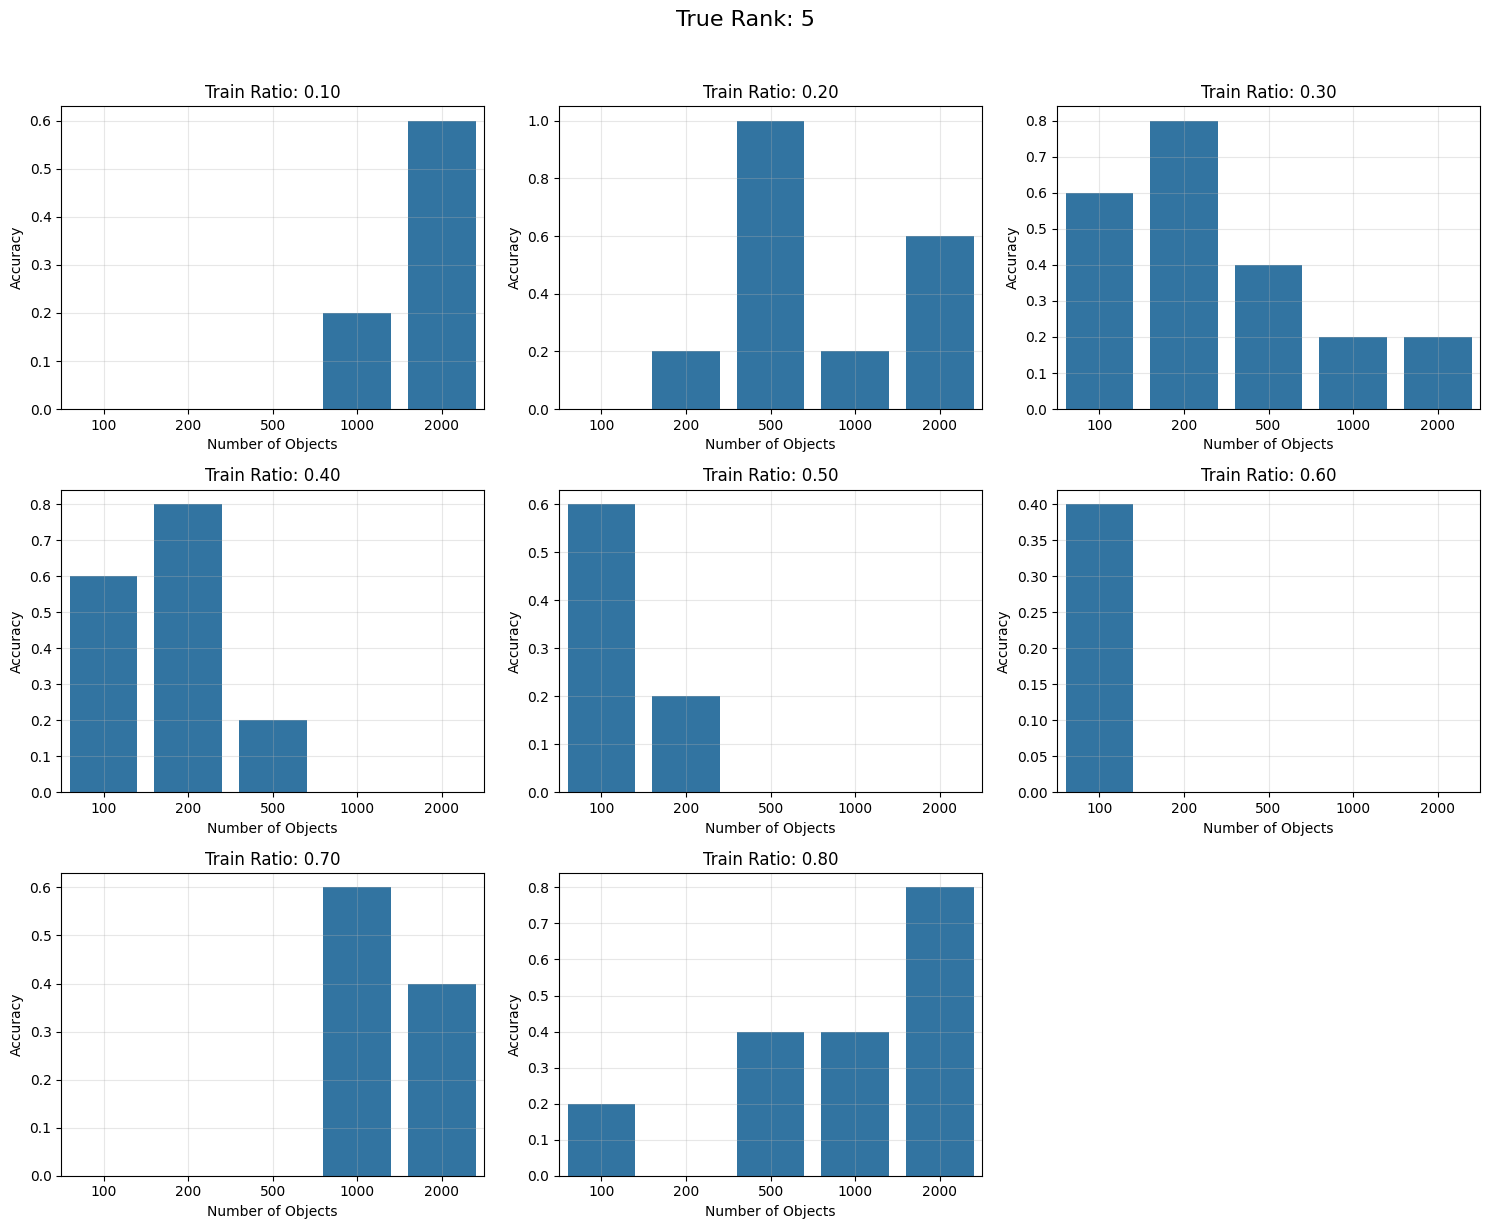

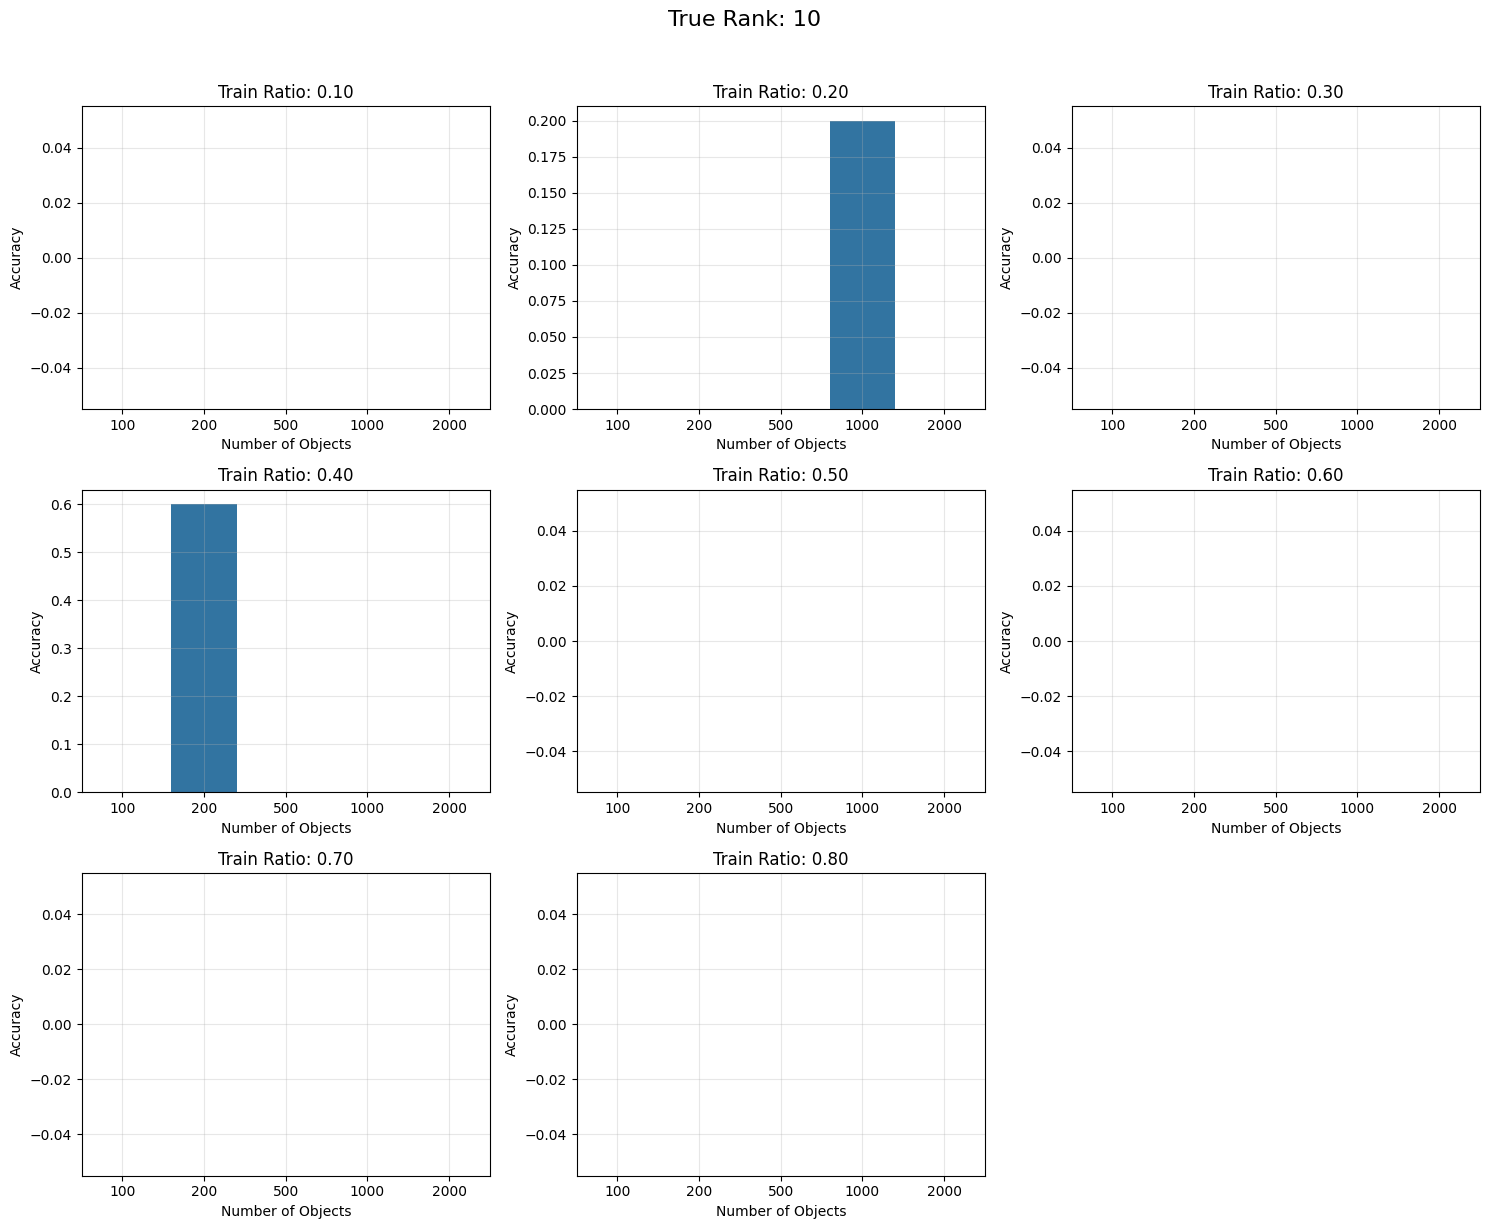

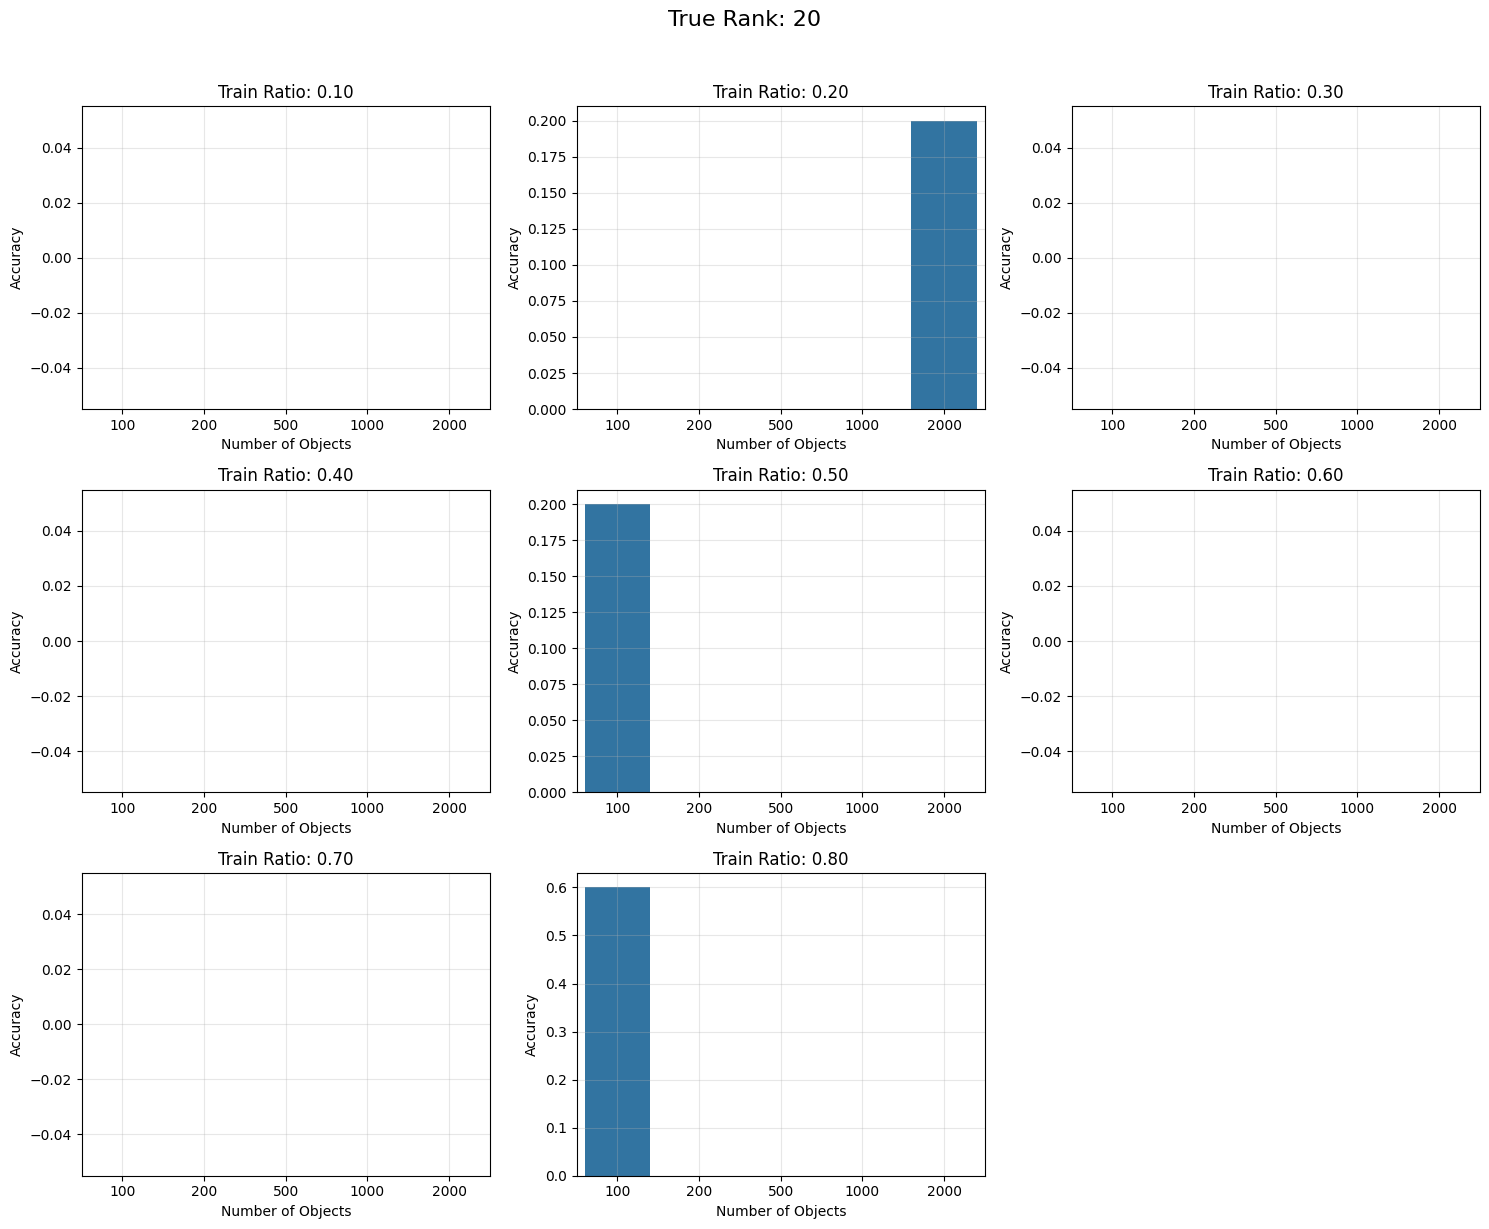

In [19]:
df = pd.read_csv("../results/rank_detection_summary.csv")

# Get unique true ranks
true_ranks = df["true_rank"].unique()

# Create a figure for each true rank
for true_rank in true_ranks:
    # Filter data for current true rank
    rank_df = df[df["true_rank"] == true_rank]

    # Get unique train ratios
    train_ratios = rank_df["train_ratio"].unique()
    n_ratios = len(train_ratios)
    n_cols = 3
    n_rows = (n_ratios + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    # Plot each train ratio in its own subplot
    for idx, ratio in enumerate(train_ratios):
        subset = rank_df[rank_df["train_ratio"] == ratio]
        sns.barplot(x="n_objects", y="accuracy_mean", data=subset, ax=axes[idx])
        axes[idx].set_title(f"Train Ratio: {ratio:.2f}")
        axes[idx].set_xlabel("Number of Objects")
        axes[idx].set_ylabel("Accuracy")
        axes[idx].grid(True, alpha=0.3)

    # Remove any empty subplots
    for idx in range(len(train_ratios), len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle(f"True Rank: {true_rank}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

### Checking the rank selection for the things-monkey dataset

In [11]:
# things-monkye
dataset = load_dataset("things-monkey-2k")

rsm = dataset.rsm
rsm_pos = (rsm - rsm.min()) / (rsm.max() - rsm.min())
n = rsm.shape[0]
repeats = 3

ratio = 0.3
df_full = find_best_rank(
    rsm_pos,
    range(5, 45, 10),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=repeats,
)

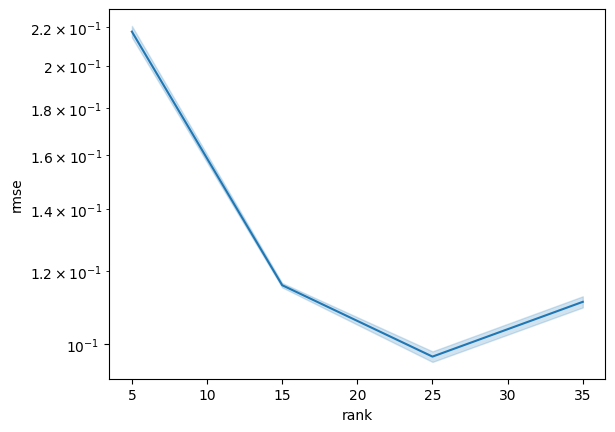

In [12]:
sns.lineplot(data=df_full, x="rank", y="rmse", errorbar="sd")
plt.yscale("log")
plt.show()